In [ ]:
import pandas as pd
from pathlib import Path
from sad2_final_project.analysis import add_missing_metrics_from_experiment, loader_obsolete_data
import os
from sad2_final_project.analysis import plot_scatter, plot_boxplot, plot_scatter_subplots

# paths
## set global dir
cwd=Path.cwd()
if cwd.name == "notebooks":
    os.chdir(cwd.parent) 
print(os.getcwd())
## create paths 
DATA_PATH2 = Path('data/trajectory_length_vs_attractors1')

df = loader_obsolete_data(DATA_PATH2 / 'results/metadata.csv', DATA_PATH2 / 'results/joined_results_trajectory_length_vs_attractors.csv')
metrics_list=['TP', 'FP', 'FN', 'precision', 'recall', 'sensitivity', 'AHD', 'SHD', 'EHD', 'SID']
df = add_missing_metrics_from_experiment(df, DATA_PATH2, metrics_list, after_column='attractor_ratio')

## Part 1 

### Numerical analysis of Bnfinder
#### Task
Construct several Boolean networks with sizes (measured by the number of nodes or variables) ranging from 5 to 16.† Each node should have no more than three parent nodes, and the Boolean functions governing individual nodes should be generated at random.

#### Goal
The goal of this study is to determine how the type and amount of time-series data generated from Boolean network dynamics affect the accuracy of dynamic Bayesian network (DBN) structure inference. In particular, we aim to identify:
- how the presence of attractor states in trajectories influences reconstruction accuracy,
- how trajectory length, sampling frequency, and the number of trajectories affects model metrics
- how these effects depend on network size and update dynamics,
- which data-generation techniques yield stable and informative reconstructions. 

---

#### Sets

To ensure reproducibility and comparisons, experiments are organized into predefined sets.
##### Groups
1. **Network size groups**
   Networks are grouped by number of nodes (every 2 from 4 to 16) to analyze scaling behavior.
2. **Update mode groups**
   Synchronous and asynchronous updates are treated separately, as they correspond to different stochastic processes (deterministic map vs stochastic transition system).
   <!-- sprawdzić  -->
3. **Scoring function groups**
<!-- TODO MICHAŁ: tutaj rozwiną o scoring functions -->
   MDL and BDe are analyzed independently. Absolute score values are not compared across scoring functions; only trends with respect to accuracy are considered.
4. **Random function sets**
   For each experimental condition, multiple independently generated Boolean networks are used.
   Random seeds are fixed per network/experiment (TODO ?) instance so that different data-generation parameters (sampling frequency, trajectory length, number of trajectories) are evaluated on identical underlying networks.
   <!-- is not possible we just need to use seed to experiments are reproducle -->

---

##### Averaging and Distributions

**Sample size normalization.**

To ensure fair comparison across different trajectory lengths, we normalize by $n_{\text{trajectories}}$ by:

$$n_{\text{trajectories}}^{\text{norm}} = \left\lceil \frac{n_{\text{nodes}} \cdot n}{L} \right\rceil$$

where:
- $n_{\text{nodes}}$ is the number of nodes in the Boolean network
- $L$ is the trajectory length
- $n$ is a normalization coefficient specifying the desired number of observations per node

This ensures that the total number of observations ($n_{\text{trajectories}} \times L$) remains approximately constant at $n_{\text{nodes}} \cdot n$, providing consistent statistical power across different trajectory lengths and unbiasdness in different conditions. We set $n = 100$, ensuring at least **10 observations per edge** (accounting for up to 3 parents per node on average we can maximally achieve $2^3$ edges). This conservative choice guarantees sufficient data for reliable network inference.

**distributions**

All reported results are based on **distributions**, not single values.
Depending on the experiment, averaging is performed over:

- trajectories (within a dataset),
- independent datasets,
- independently generated networks.

The aggregation strategy is explicitly chosen for each experiment to match the source of variability under investigation.

In [ ]:
df1 = df[df["trajectory_length"]>=10]

## Determinants of Reconstruction Accuracy

The primary objective of this analysis was to identify the key factors influencing the accuracy of Boolean network reconstruction using dynamic Bayesian networks (DBNs). Specifically, we investigated how properties of the generated data (attractor ratio, trajectory length), network characteristics (number of nodes), and inference configuration (update mode and scoring function) affect reconstruction quality as measured by standard performance metrics.

### Exploratory Correlation Analysis

We first conducted a pairwise correlation analysis between data characteristics and reconstruction metrics (precision, recall, SHD, and AHD). 

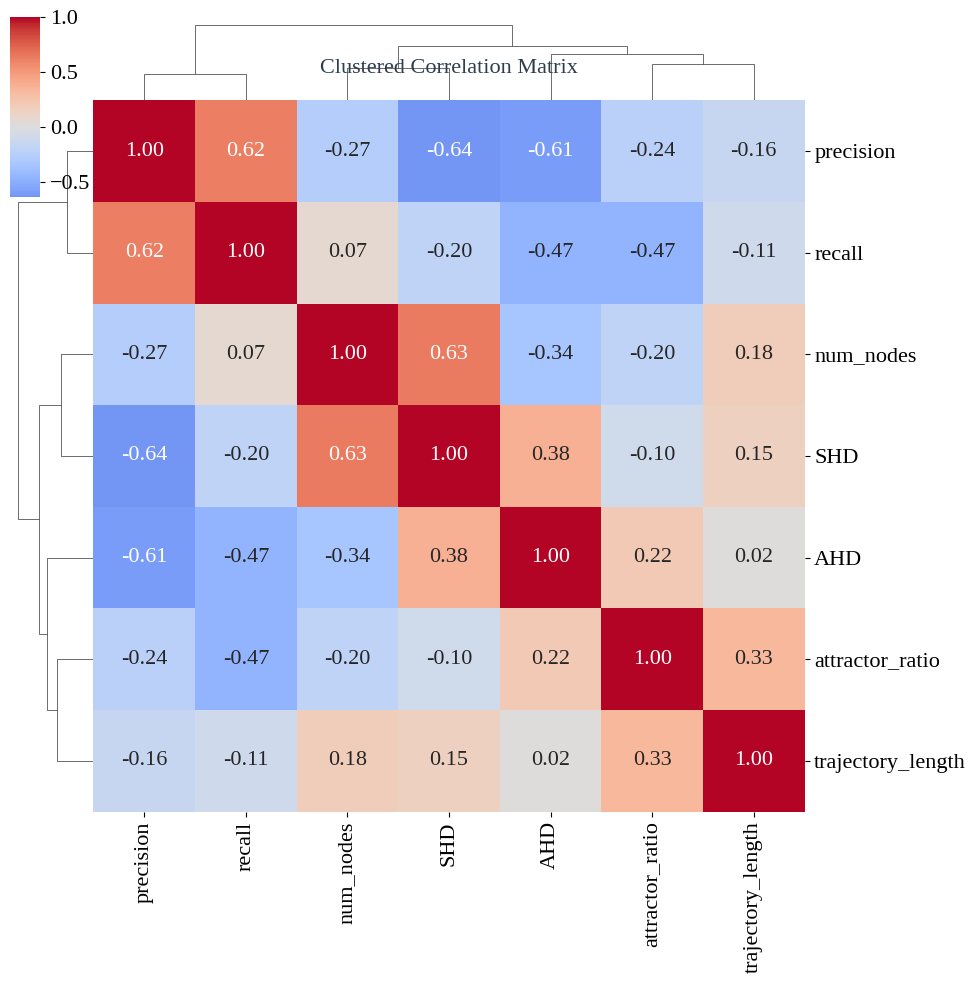

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
corr_matrix = df[['attractor_ratio', 'num_nodes', 'trajectory_length', 'precision', 'recall', 'SHD', 'AHD']].corr()
g = sns.clustermap(corr_matrix, 
                   annot=True, 
                   cmap="coolwarm",
                   fmt=".2f",
                   figsize=(10, 10),
                   row_cluster=True,
                   col_cluster=True,
                   center=0,
                   dendrogram_ratio=0.1,
                   cbar_pos=(0.02, 0.8, 0.03, 0.18))
g.ax_heatmap.set_title("Clustered Correlation Matrix", fontsize=16, pad=20)
plt.show()

This exploratory step revealed several notable relationships:

- **Attractor ratio** exhibited a strong negative correlation with recall (r = –0.47), indicating that datasets dominated by attractor states substantially impair the recovery of true regulatory interactions.
- **Network size (number of nodes)** showed a strong positive correlation with SHD (r = 0.63), confirming that reconstruction error increases with network complexity.
- **Trajectory length** displayed near-zero correlations with all performance metrics, suggesting that its effect is not uniform and likely depends on interactions with other factors.

These findings suggested that both data composition and network scale play important roles in reconstruction performance, motivating a multivariate analysis to disentangle their independent effects.

---

### Multivariate Regression Analysis

To quantify the independent contribution of each factor while controlling for others, we fitted ordinary least squares (OLS) regression models for structural error (SHD) and adjacency error (AHD). The primary model for SHD included attractor ratio, trajectory length, number of nodes, update mode, scoring function, and an interaction between attractor ratio and trajectory length:

```
SHD ~ attractor_ratio × trajectory_length + num_nodes + update_mode + score_function
```


In [ ]:
import statsmodels.formula.api as smf

model = smf.ols(
    "SHD ~ attractor_ratio * trajectory_length + num_nodes + update_mode + score_function",
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    SHD   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     2332.
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:43:32   Log-Likelihood:                -71233.
No. Observations:               18000   AIC:                         1.425e+05
Df Residuals:                   17993   BIC:                         1.425e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

The model explained approximately 44% of the variance in SHD (R² ≈ 0.44), indicating substantial explanatory power. The following effects were statistically significant:

- **Attractor ratio** had a strong positive effect on SHD, demonstrating that a higher proportion of attractor states in the data leads to increased structural reconstruction error.
- **Update mode** (synchronous vs. asynchronous) exerted a large effect, with synchronous updates yielding significantly higher error. This result was expected, as synchronous dynamics reduce the diversity of observable transitions, effectively decreasing the informational content of the data.
- **Scoring function** had a strong effect, with MDL outperforming BDe in terms of lower structural error.
- **Trajectory length** had a smaller but statistically significant effect on SHD, indicating that longer trajectories do not necessarily improve reconstruction accuracy under fixed sample size conditions.

---

### Interaction Effects and Mechanistic Insight

To further investigate how data characteristics interact, we fitted a second regression model for adjacency error (AHD) including the interaction term:

```
AHD ~ attractor_ratio × trajectory_length + num_nodes + update_mode + score_function
```

In [ ]:
model2 = smf.ols(
    "AHD ~ attractor_ratio * trajectory_length + num_nodes + update_mode + score_function",
    data=df
).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                    AHD   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     832.7
Date:                Sat, 24 Jan 2026   Prob (F-statistic):               0.00
Time:                        14:46:54   Log-Likelihood:                 10722.
No. Observations:               18000   AIC:                        -2.143e+04
Df Residuals:                   17993   BIC:                        -2.138e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

This model revealed a significant negative interaction between attractor ratio and trajectory length, indicating that longer trajectories partially mitigate the detrimental effect of high attractor dominance. In other words, while attractor-heavy datasets are generally less informative, increasing trajectory length can partially compensate by providing more opportunities to observe transient dynamics.

---

### Summary of Determinants

Overall, reconstruction accuracy was primarily influenced by:

1. **Update mode**, which strongly affected performance due to differences in the stochasticity and informational richness of the generated trajectories. This effect is intuitive, as reduced dynamical variability limits the ability to infer causal relationships.
2. **Scoring function**, with MDL consistently outperforming BDe under the studied conditions.
3. **Attractor ratio**, which emerged as the most influential data-related factor, particularly impairing recall and increasing structural error.
4. **Network size**, which substantially increased structural error due to scaling complexity.
5. **Trajectory length**, which had a secondary, interaction-dependent effect rather than a uniform influence.

These findings demonstrate that reconstruction accuracy is jointly determined by data composition, network complexity, and inference configuration, with attractor dominance playing a central role in limiting the informativeness of time-series data.



TODO JOANNA:
- trzeba to rozbić (wszystkie inne wykresy także) na synchronoous i asynchronous - to są dwa rózne sposoby aktualizacji i powoduje że występują zupełnie inne zależności i każdy trzeba opisywać osobno
- JAK ZROBIŁĄŚ TUTAJ 'BDe' TO KONIECZNIE trzeba MDL bo te funkcje kosztu inaczej na to mogą reagować i to trzeba uwzględnić. Tutaj można podzielić wnioski na:
    - dotyczące miar dopasowania (precission, recall, sensitivity itd.) one nam mówią jak dobre jest dopasowanie wyjściowy model i przewidziany
    - score function (MDL, BDE) mówią nam jakie jest dopasowanei DANE przewidziany model
    - to są inne pojęcia i trzeba je rozpatrzyć osobno  

- te scatter ploty
    - spoko ale bym chyba tylko score_function zobaczył, bo to jest ważne podczas trenowania ponieważ:
        - relacja z miarami jakości - czy 

- te short trajectory itd. spoko, ale bym głwnie sieskupił na tym median_ar vs scale_aratio i jak masz ten gragment na 0.6 to jst okolo 0.8 bo sprawdzałem dane i chciałym żebyś t zrobiła dla wszystkich da oraz podzieliła na grupy itd. poniewaz:
    - z tego robimy główny wniosek czyli jaka jest relacja: $\mathrm{num_nodes} \sim \mathrm{trajectory_length}$ i jak tak na szybko patryłem t te kroki są w zasięgu tak jak wyżej 0.8
    - tutaj skomentować że wyniki są statystycznie istotne (dlaczego?) - nie mamy testów ALE mamy duże grupy i t musisz zrobić, zliczyć ile przypadków jest na każdą taka kropkę, czyli zrobic pivot tiable po tychj zmiennych co liczysz i funkcja agregacji to 'size' jak jest dużo próbek to wynik istotnym i ograniczamy się do tego ponieważ w mniejszym przedziale nie mamy danych
    - wiec nie do długości wnioskuj ale do relacji $\mathrm{num_nodes} \sim \mathrm{trajectory_length}$
    - jeszcze trzeba zmodyfikować metododlogie gdzie opiszesz - jaki jest główny cel tego fragmentu i po krótce jakie są kolejne kroki które wykonujesz - jak napiszesz całośc z tego to mogę to zrobić. 

UWAGA1, 

teraz mamy jeden wspólny df, polcecam pobrać i załadować i wtedy ewentualnie podczas analiz dzielic na df z jakąś ilością warunków itd. albo warunki od do indeksu (bo jest indeks złączenia, można go sobie zapisać, t jest chyba 18_000)

UWAGA2

Ja o tym że to są dwie różne klasy abstrakcji i dlaczego to rozbijamy osobno oraz z tymi funkcjami kosztu czym i dlaczego się różnią i dlaczego rozpatrujemy osobno napiszę we wstępie do metodologii

UWAGA3

fajny pomysł z korelacją, w sumie o tym nie pomyślałem a jest najprostsze i od razu widać, ALE ZASTANÓW SIĘ JAKA PONIEWAŻ teraz jest słabo dobrana, nie wiem jaka mocna w statystyke jesteś ale daje do rozkminy bo widze ambitność w działaniu :) 

UWAGA 4 

Jeżeli sama to pisałaś to jest to bardzo dobrze napisane - do celu wytłumaczne dlaczego itd., jedyne czasami rozumowanie nie w tą stronę, ale miałaś mało czasu żeby się przygotować. Można to zauważyć po ilości uwag, bo jak widzę że ktos olewa to po prostu już macham ręką :) .



### Visualizing the Impact of Attractor Ratio on Reconstruction Error

To complement our regression analysis and gain an intuitive understanding of how **attractor dominance interacts with scoring function and update mode**, we generated scatter plots of **SHD, AHD, BDe and MDL versus attractor ratio**, stratified by **synchronous and asynchronous updates**.

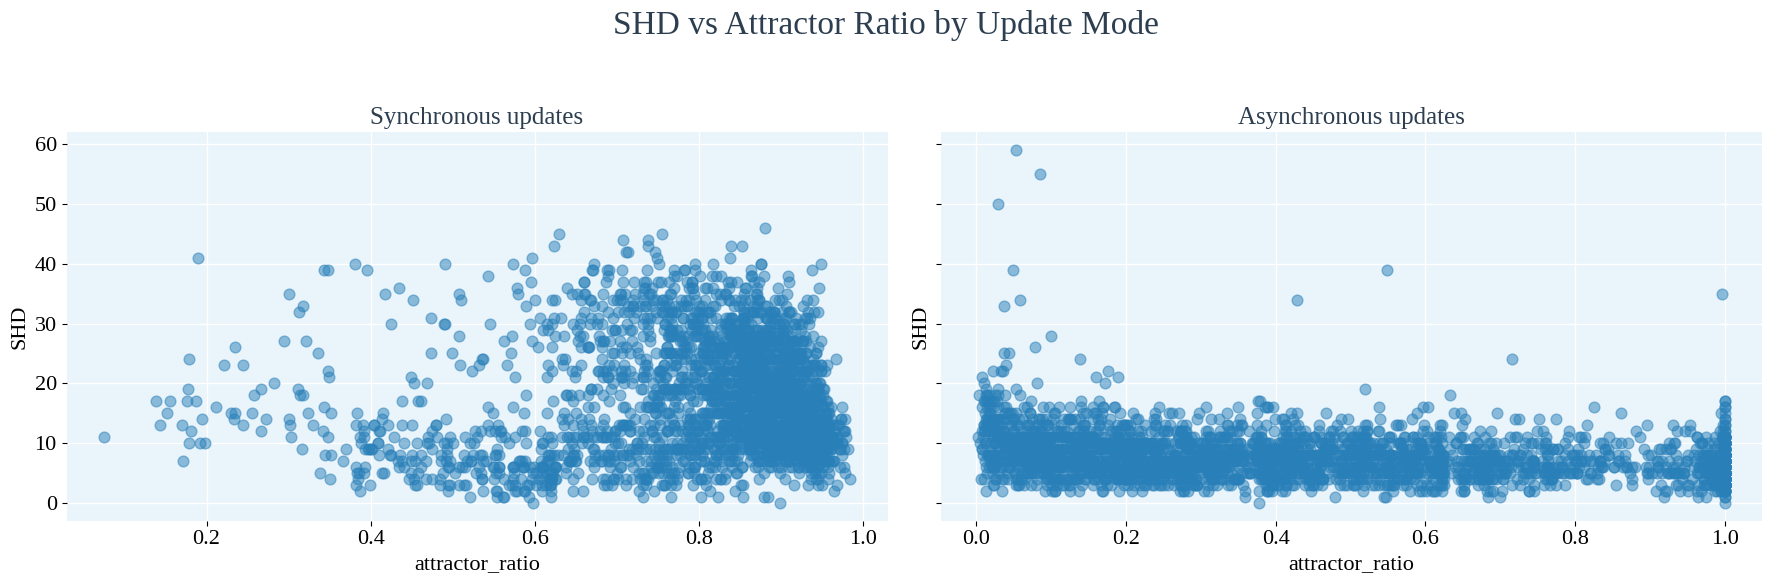

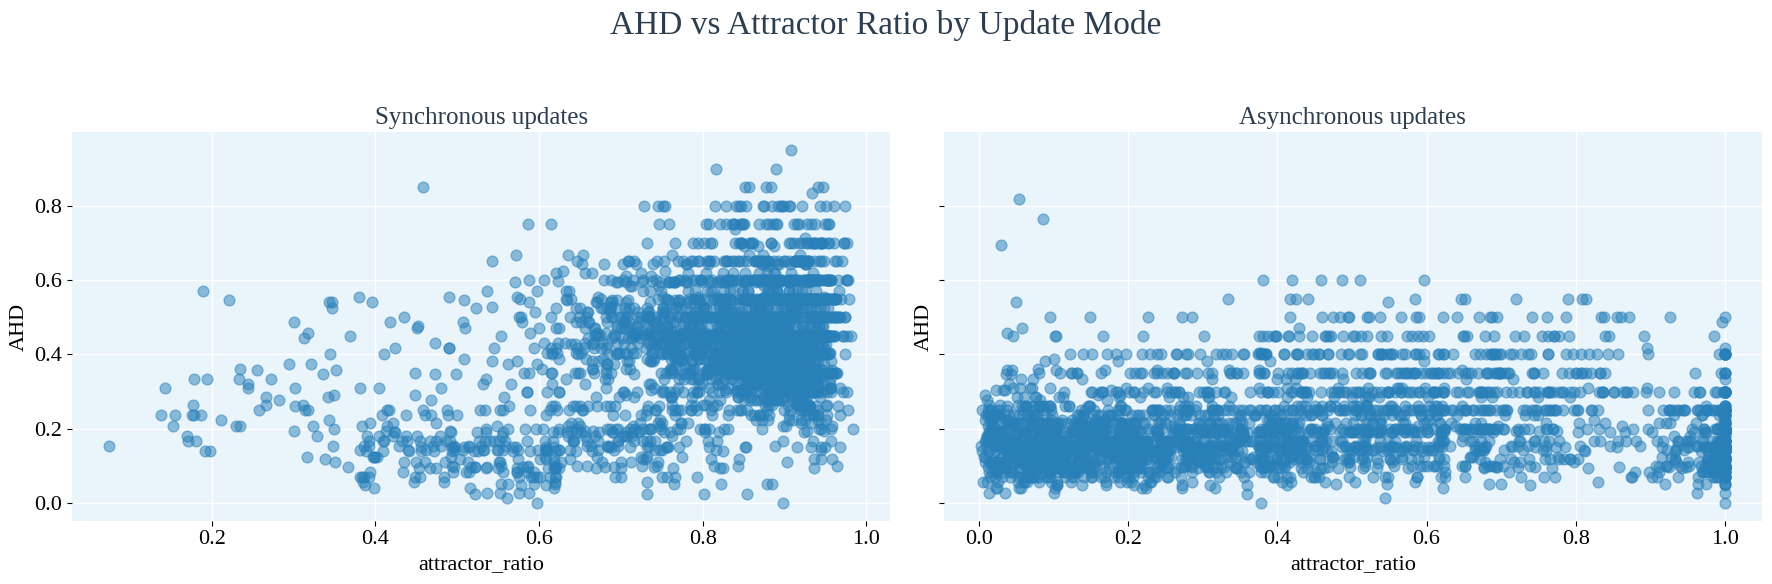

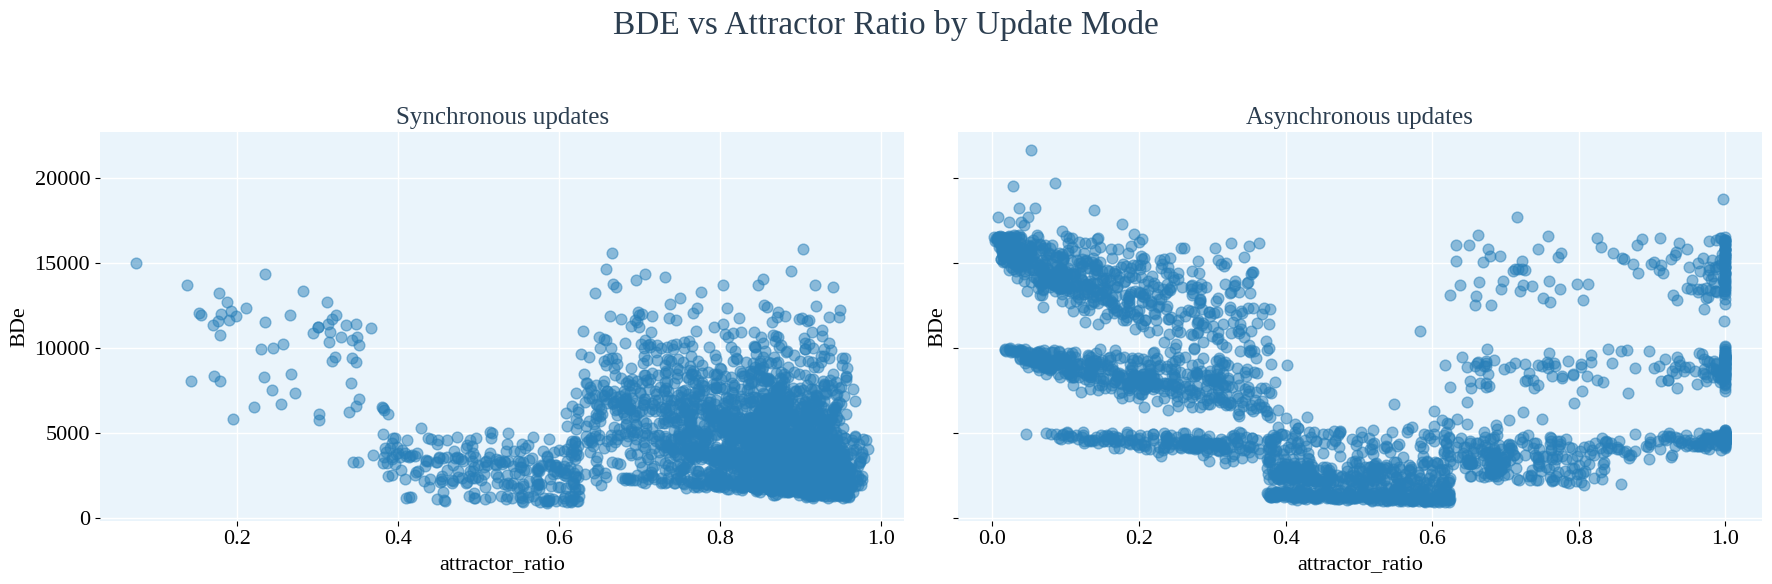

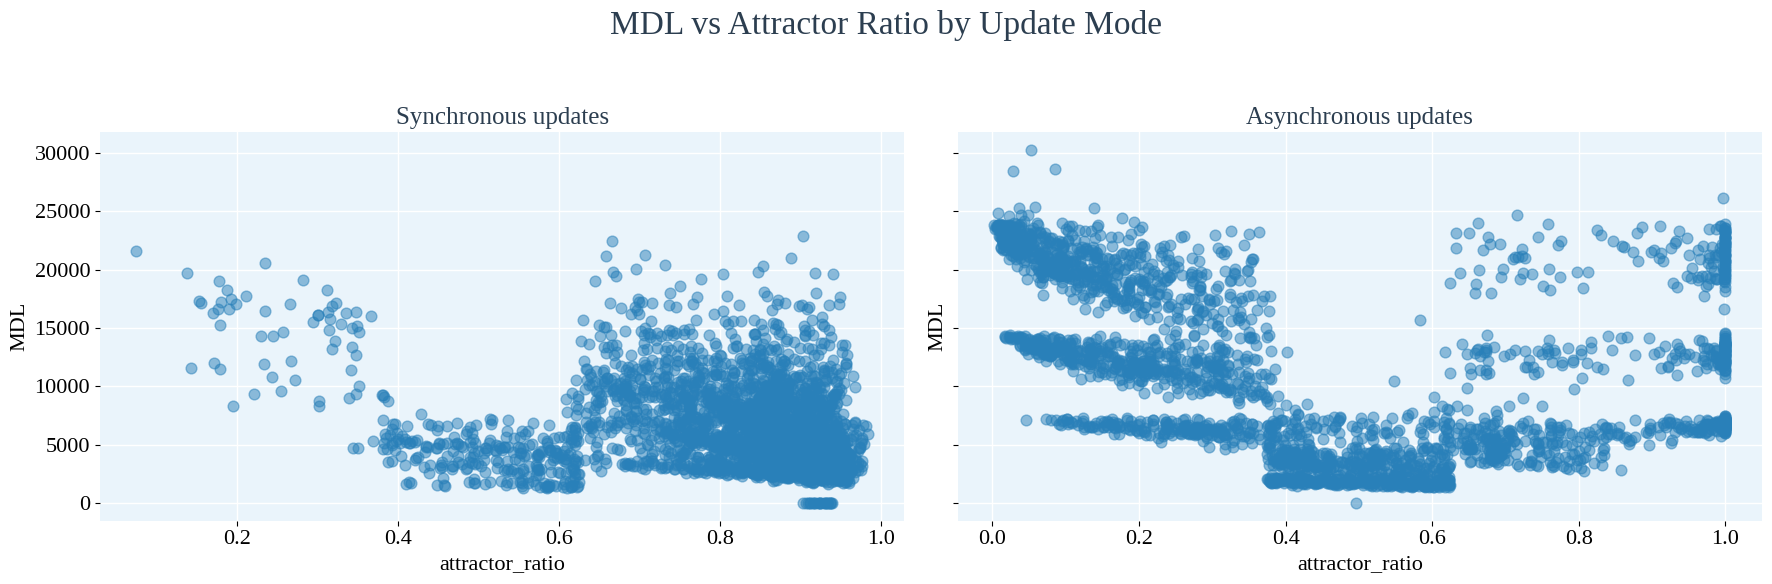

In [ ]:
category_colors = ['#C0392B', '#2980B9', '#27AE60', '#F4D03F', '#8E44AD']

plot_scatter_subplots(df1, x='attractor_ratio', y='SHD', title='SHD vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='AHD', title='AHD vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='BDe', title='BDE vs Attractor Ratio by Update Mode')
plot_scatter_subplots(df1, x='attractor_ratio', y='MDL', title='MDL vs Attractor Ratio by Update Mode')

##### Results:

* In the **SHD plots**, under **synchronous updates**, most points are clustered at **high attractor ratios (>0.6)**, with SHD ranging broadly from **0 to 40**, reflecting the substantial structural error associated with attractor-dominated datasets. In contrast, **asynchronous updates** show attractor ratios spanning the full range, but SHD is generally much lower for low attractor ratio trajectories, increasing gradually up to **~15** and then **~10**, confirming that asynchronous dynamics produce more informative trajectories.
* For **AHD**, synchronous updates again concentrate at **attractor ratios >0.6**, with AHD ranging between **0.1–0.8**, whereas asynchronous updates cover the full attractor range but exhibit a dense cluster near **0–0.4**, indicating overall lower adjacency errors compared to synchronous dynamics.
* For **BDe**, synchronous updates concentrate mostly at **attractor ratios >0.6, with BDe ranging between 0.0-1500**. In asynchronous updates, however, a downward trend in BDe can be observed for the atraktor_ratio range of 0.0-0.4. After that, most of the values ​​accumulate close to zero.
* For **MDE** the situation was identical to that for BDe.

Together, these scatter plots visually confirm our earlier findings: **high attractor ratios are associated with greater reconstruction errors**, and the **update mode strongly shapes the distribution of errors**, with asynchronous updates producing generally more accurate reconstructions. These visualizations provide a bridge to investigating **which factors influence attractor prevalence**, a key driver of reconstruction difficulty.

**This observation motivates the next step of our study: since attractor ratio is a key driver of reconstruction error, we now investigate which network- and data-generating factors determine the prevalence of attractor states in Boolean network trajectories.**

##### 1. Relation Between Trajectory Length and Entering Attractors

**Objective.**
To characterize how trajectory length is related to the probability of entering attractors as a function of network size and dynamics.

**Experimental design.**

- The target attractor proportion is **not controlled**; trajectories evolve naturally.
- Trajectory lengths are varied in increments proportional to network size:
    - from 10 steps to 50 by 10
- Networks are grouped by size (from 4 to 16 nodes, in steps of two).
- The number of parents per node is randomly chosen from set of $\{1,2,3\}$ to avoid conditioning results on a fixed connectivity pattern.

**Measured quantities.**

- Probability of reaching an attractor as a function of trajectory length.
- How different groups (below TODO - inner link) differ in in this probability.

**Rationale.**
Attractor entry is an emergent property of the dynamics. Controlling it directly is undesirable, as it would introduce selection bias. This experiment instead characterizes the **natural scaling behavior** of Boolean network dynamics.


(<Figure size 1300x500 with 1 Axes>,
 <Axes: title={'center': 'Asynchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes'}, xlabel='trajectory_length', ylabel='attractor_ratio'>)

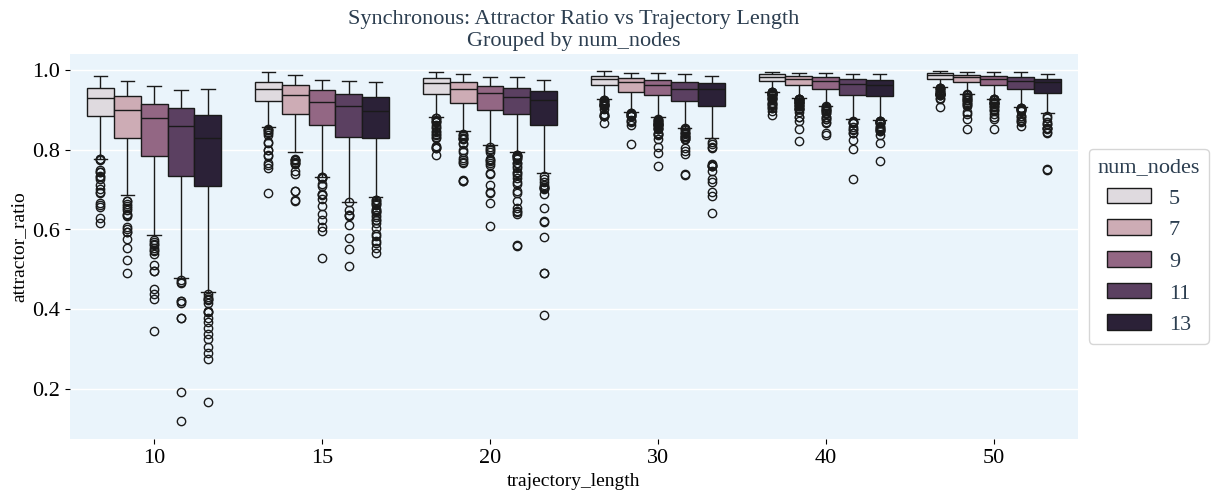

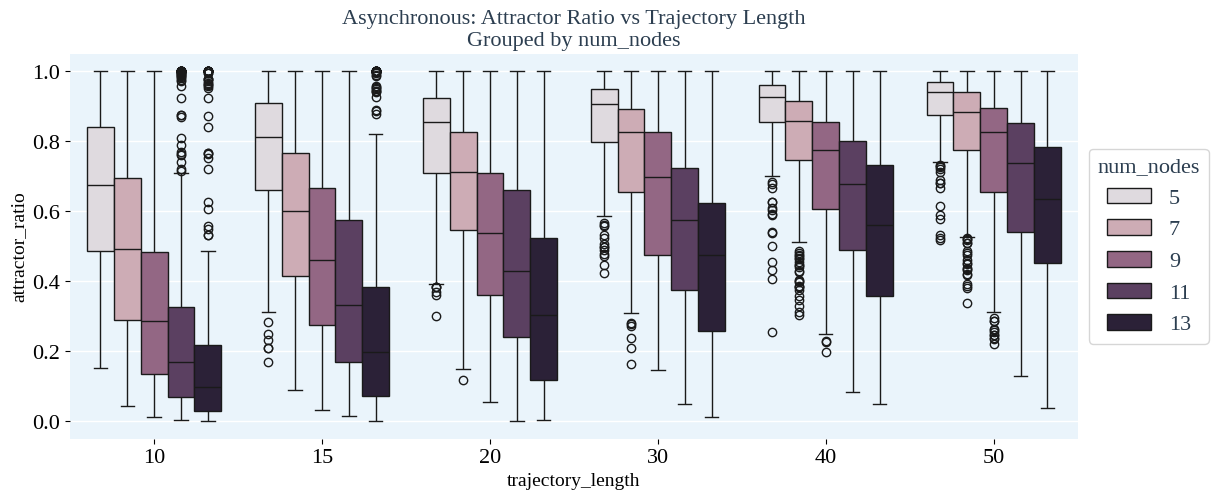

In [13]:
category_colors = ['#C0392B', '#2980B9', '#27AE60', '#F4D03F', '#8E44AD']

df_synchronous = df1[df1["update_mode"]=="synchronous"]
df_asynchronous = df1[df1["update_mode"]=="asynchronous"]

# Boxplot grouped by num_nodes synchronous
plot_boxplot(df_synchronous, x='trajectory_length', y='attractor_ratio', hue='num_nodes',
             title='Synchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes')
# Boxplot grouped by num_nodes synchronous
plot_boxplot(df_asynchronous, x='trajectory_length', y='attractor_ratio', hue='num_nodes',
             title='Asynchronous: Attractor Ratio vs Trajectory Length\nGrouped by num_nodes')

### Results

To further explore the factors influencing attractor prevalence, we generated boxplots of **attractor ratio versus trajectory length**, grouped by **network size (num_nodes)**, separately for **synchronous** and **asynchronous** updates.

* **Synchronous updates:** attractor ratios are generally higher across all trajectory lengths, consistent with the expected behavior of synchronous Boolean networks, where simultaneous node updates tend to drive the system more quickly into attractor states.
* **Asynchronous updates:** attractor ratios are lower overall and more widely distributed, reflecting the increased variability and longer transient dynamics inherent to asynchronous update schemes.

Across both update modes, we observe consistent trends:

1. **Trajectory length effect:** attractor ratio tends to increase with longer trajectories.
2. **Network size effect:** attractor ratio tends to decrease as the number of nodes increases.

These observations visually confirm the patterns suggested by our regression and scatter plot analyses, providing an intuitive view of how **update mode, trajectory length, and network size jointly shape attractor prevalence** in simulated Boolean networks.

### 4. Scaling Law Analysis: Normalizing Trajectory Length by Network Size

To systematically compare how trajectory length and network size jointly influence convergence, we introduced a **scaling metric**: the **scale_ratio**, defined as `trajectory_length / num_nodes`. This metric normalizes the simulation time by the network’s complexity, allowing us to identify a unified scaling behavior across different system sizes.

,trajectory_length,num_nodes,median_ar,q25_ar,mean_ar,std_ar,n,scale_ratio
0,5,5,0.744275,0.456143,0.663274,0.256694,600,1.000000
1,5,7,0.592857,0.235679,0.533909,0.301724,600,0.714286
2,5,9,0.433069,0.099973,0.444428,0.331446,600,0.555556
3,7,5,0.787927,0.565556,0.719998,0.231840,600,1.400000
4,7,7,0.699449,0.339643,0.611798,0.298881,600,1.000000


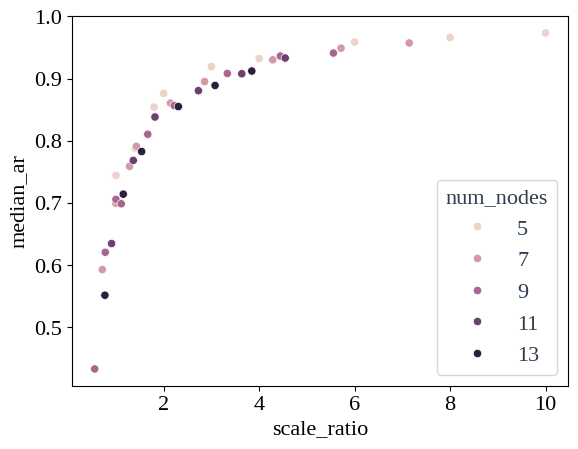

In [22]:
df_summary = (
    df
    .groupby(["trajectory_length", "num_nodes"])
    .agg(
        median_ar=("attractor_ratio", "median"),
        q25_ar=("attractor_ratio", lambda x: x.quantile(0.25)),
        mean_ar=("attractor_ratio", "mean"),
        std_ar=("attractor_ratio", "std"),
        n=("attractor_ratio", "size")
    )
    .reset_index()
)

df_summary["scale_ratio"] = (
    df_summary["trajectory_length"] / df_summary["num_nodes"]
)

import seaborn as sns
sns.scatterplot(
    data=df_summary,
    x="scale_ratio",
    y="median_ar",
    hue="num_nodes"
)
df_summary.head()

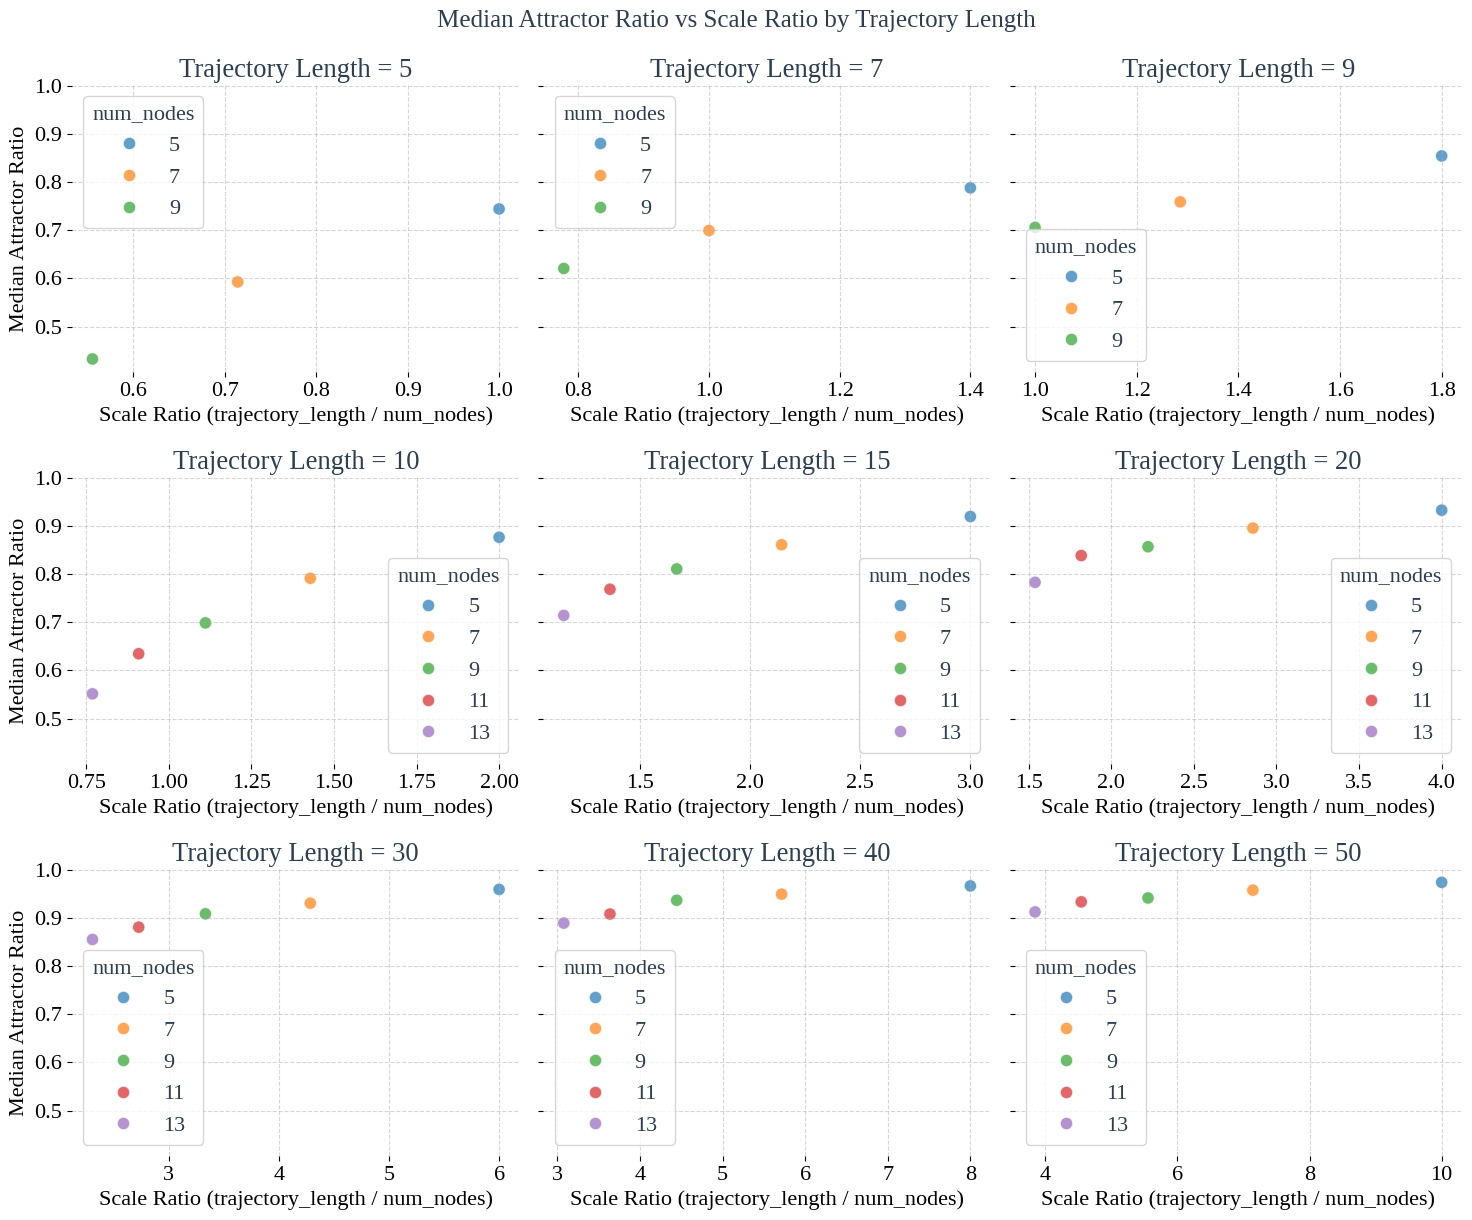

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

traj_lengths = sorted(df_summary['trajectory_length'].unique())
n_cols = 3  
n_rows = (len(traj_lengths) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows), sharey=True)
axes = axes.flatten()  
for i, traj_len in enumerate(traj_lengths):
    ax = axes[i]
    df_sub = df_summary[df_summary['trajectory_length'] == traj_len]

    sns.scatterplot(
        data=df_sub,
        x="scale_ratio",
        y="median_ar",
        hue="num_nodes",
        palette="tab10",
        s=80,
        alpha=0.7,
        ax=ax
    )

    ax.set_title(f"Trajectory Length = {traj_len}")
    ax.set_xlabel("Scale Ratio (trajectory_length / num_nodes)")
    ax.set_ylabel("Median Attractor Ratio")
    ax.grid(True, linestyle="--", alpha=0.5)

    for spine in ax.spines.values():
        spine.set_visible(False)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
fig.suptitle("Median Attractor Ratio vs Scale Ratio by Trajectory Length", fontsize=18, y=1.02)
plt.show()


##### Results

From the subplots of **median attractor ratio (`median_ar`) versus scale ratio (`trajectory_length / num_nodes`)**, several clear patterns emerge:

* **Positive relationship with scale ratio:** In general, the median attractor ratio increases as the scale ratio grows. This indicates that networks with relatively longer trajectories compared to their size tend to spend more time in attractor states.
* **Effect of trajectory length:** For larger trajectory lengths, the median attractor ratio remains high even for small scale ratios. This suggests that longer trajectories provide more opportunities for the system to reach attractor states, regardless of network size.
* **Group-level consistency:** These trends are consistent across different network sizes (`num_nodes`) and are particularly evident in groups with a sufficiently large number of observations, which ensures that the results are statistically robust.

In [ ]:
# Global parameters
NUM_NODES = [i for i in range(5, 17, 2)] # od 5 do 15 (włącznie) wierzchołków, co dwie krawędzie
SCORE_FUNCTIONS = ["MDL", "BDE"]
UPDATE_MODE = ["synchronous", "asynchronous"]
N_PARENT_PER_NODE = [[1, 2, 3]]
N_REPETITIONS = 30 

In [ ]:
# create experiments:
## case: Relation between trajectory length and entering attractors
exp_trajectory_length = BooleanNetworkExperiment(
    ### paths
    data_path=DATA_PATH,
    experiment_name='trajectory_length_vs_attractors',
    
    ### Tested variables 
    trajectory_length=[10, 15, 20, 30, 40, 50],
    n_trajectories=[100], 
    sampling_frequency=[1, 2, 3, 4, 5],

    ### Constant values per experiment 
    n_repetitions=30,
    n_parents_per_node=N_PARENT_PER_NODE,

    ### Groups (bo wszędzie takie same)
    num_nodes=NUM_NODES,
    score_functions = SCORE_FUNCTIONS,
    update_mode=UPDATE_MODE,

    simulate_trajectories_to_csv_kwargs = {
            # "sampling_frequency": 1,
            "target_attractor_ratio": 0.5,  # Approximate fraction of trajectory in attractor (0-1)
            "tolerance": 0.125,               # Allowed deviation from the calculated entrance step (0-1)
        }
)
# standardize sample  
exp_trajectory_length.normalize_sample(100) # WAŻNE NORMALIZUJE PRÓBĘ 
exp_trajectory_length.show_experiment_df()

# trzeba zrbić funkcje która nam ustawia względem trajektori n_trajectorii trajectory lenght * n_trajectories / k = num_nodes * 100 i tym k dzielimy n_trajectories i dajemy int'a 

,num_nodes,update_mode,trajectory_length,n_trajectories,sampling_frequency,score_function,n_parents_per_node,rep_id,condition_id,success,attractor_ratio
0,5,synchronous,10,50,1,MDL,"[1, 2, 3]",0,0000,False,NaN
1,5,synchronous,10,50,1,MDL,"[1, 2, 3]",1,0001,False,NaN
2,5,synchronous,10,50,1,MDL,"[1, 2, 3]",2,0002,False,NaN
3,5,synchronous,10,50,1,MDL,"[1, 2, 3]",3,0003,False,NaN
4,5,synchronous,10,50,1,MDL,"[1, 2, 3]",4,0004,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
21595,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",25,21595,False,NaN
21596,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",26,21596,False,NaN
21597,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",27,21597,False,NaN
21598,15,asynchronous,50,30,5,BDE,"[1, 2, 3]",28,21598,False,NaN


In [ ]:
exp_trajectory_length.run_experiment(n_jobs=1)

##### 2. Impact of Sampling Frequency

**Objective.**
To determine how temporal subsampling affects autocorrelation, effective sample size, and reconstruction accuracy.

Dynamic Bayesian network inference assumes conditional independence of observations given parent states in the previous time slice. Excessive temporal dependence violates this assumption in practice by introducing redundant observations.

**Experimental design.**

- For fixed networks and trajectory lengths, datasets are generated using multiple sampling frequencies (1, 2, 3, 4, 5).
- For each dataset
    - ACF and ESS are computed,
    - MDL and BDe scores are extracted from BNFinder2 logs,

**Analysis.**
Accuracy is analyzed jointly as a function of: 
<!-- What does it mean jointly ?? -->

* sampling frequency,
* ESS,
* scoring function (MDL or BDe).

**Rationale.**
This experiment identifies sampling regimes that balance reduced autocorrelation against loss of dynamic information due to over-subsampling.

---

##### 3. Amount of Trajectories Required for Stable Inference

**Objective.**
To determine how many independent trajectories are required to obtain statistically stable reconstructions.

**Experimental design.**

- Sampling frequency and trajectory length are fixed to values identified as near-optimal in previous experiments.
- The number of trajectories per dataset is gradually increased - from 10 to 100 by 10.
- For each setting, multiple (30) independent repetitions are performed to obtain convergent distribution .

**Evaluation.**

- Reconstruction accuracy is summarized using distributions (score functions).
- Stability is assessed by observing convergence of accuracy metrics as the number of trajectories increases.
- No classical parametric hypothesis test is assumed; instead, convergence trends is reported.
<!-- Nie znalazłem żadnego sensownego -->

**Rationale.**
Due to the randomness of Boolean functions and initial states, averaging over multiple networks is necessary to separate systematic effects from instance-specific variability.


In [ ]:
# create experiments:
## case: Relation between trajectory length and entering attractors
exp_trajectory_length = BooleanNetworkExperiment(
    ### paths
    data_path=DATA_PATH,
    experiment_name='trajectory_length_vs_attractors',
    
    ### Tested variables 
    trajectory_length=list(30), # TODO TESTS: SET VALUE 
    n_trajectories=[50],
    sampling_frequency=[1], #TODO TESTS: SET VALUE 

    ### Constant values per experiment 
    n_repetitions=N_REPETITIONS,
    n_parents_per_node=N_PARENT_PER_NODE,

    ### Groups (bo wszędzie takie same)
    num_nodes=NUM_NODES,
    score_functions = SCORE_FUNCTIONS,
    update_mode=UPDATE_MODE,

    simulate_trajectories_to_csv_kwargs = {
            # "sampling_frequency": 1,
            "target_attractor_ratio": 0.5,  # Approximate fraction of trajectory in attractor (0-1)
            "tolerance": 0.5,               # Allowed deviation from the calculated entrance step (0-1)
        }
) 
exp_trajectory_length.show_experiment_df()

#### Analysis

In [ ]:
# ANALIZA - będziemy robić do wszystkie wstępny opis po co jakie ploty i potem robić ploty i potem je omawiać 

## Part 2

## 1. Choose validated Boolean network
### Task
Our task is to consider a validated Boolean network model of a real-life biological mechanism. To this end, select a Boolean network 2 model of your choice from the ‘models’ subfolder of the Biodivine repository, available at https://github.com/sybila/biodivine-boolean-models, with the number of nodes (variables) not exceeding 16.‡.
### Dataset
We have chosen to analise the model 'model_id_37' available in the Biodivine repository. This model consists of 11 nodes and 5 inputs and represents a biological mechanism suitable for our network inference task - targeted breast cancer therapy and individual drug response in different breast cancer cell types.


In [ ]:
from sad2_final_project.boolean_bn import load_bnet_to_BN

chosen_model = 'model_id_37'
model = load_bnet_to_BN(MODELS_PATH / chosen_model / 'model.bnet')

Loaded 16 nodes. Mapping:
  x0: v_AKT
  x1: v_EGF
  x2: v_ERBB1
  x3: v_ERBB2
  x4: v_ERBB3
  x5: v_ERK1_2
  x6: v_HRG
  x7: v_MEK1_2
  x8: v_PDK1
  x9: v_PKCa
  x10: v_PLCg
  x11: v_erlotinib
  x12: v_mTOR
  x13: v_p70S6K
  x14: v_pertuzumab
  x15: v_trastuzumab
eee


KeyboardInterrupt: 

## 2. Generate dataset
#### Task
Using the insights gained from the first part of the project,
generate an appropriate dataset for the network inference task. 




In [ ]:
NUM_NODES_FINAL = [0]
SCORE_FUNCTIONS_FINAL = ["MDL", "BDE"]
UPDATE_MODE_FINAL = ["synchronous", "asynchronous"]
N_PARENT_PER_NODE_FINAL = [[1, 2, 3]]

Loaded 16 nodes. Mapping:
  x0: v_AKT
  x1: v_EGF
  x2: v_ERBB1
  x3: v_ERBB2
  x4: v_ERBB3
  x5: v_ERK1_2
  x6: v_HRG
  x7: v_MEK1_2
  x8: v_PDK1
  x9: v_PKCa
  x10: v_PLCg
  x11: v_erlotinib
  x12: v_mTOR
  x13: v_p70S6K
  x14: v_pertuzumab
  x15: v_trastuzumab
eee


KeyboardInterrupt: 

## 3. Reconstruct the network with BNFinder2
### Task
Reconstruct the network structure with BNFinder2, applying a scoring function chosen based on your previous
experience. Evaluate the accuracy of the reconstruction.

In [ ]:
# TODO MAX: raport zliczenie jakości dopasowania
from sad2_final_project.bnfinder.metrics import evaluate_results_metrics

results = evaluate_results_metrics('tmp', 'tmp', metrics_list=['TP', 'FP', 'TN', 'presicion', 'recall', 'sensitivity', 'AHD', 'SHD', 'EHD', 'SID'])


Informacja do tych sieci do eksperymentów numerycznych
- grupy
    - synchroniczne / asynchroniczne
    - ilość wierzchołków
    - funkcje optymalizacji 
- zmienne latentne
    - wpadania do atraktorów 
    - za
- zmienne kontrolowane 
    - długość trajektorii 
    - ilość trajektorii 
    - ilość prób (do stworzenia rozkładu) 
- stałe
    - ilość rodziców na wierzchołek, (to musi byc losowe, badanie tego typu jest pytaniem ilośc atraktorów $\sim$ ilość rodziców - nie interesuje nas to)



UWAGA
- dodać flage to experimentu, z usuwaniem folderów (testow można puścić wtedy) 

Klasy do robienia analiz (osobne skrypty)
- analysis
    - klasa która przyjmuje metadane, oraz zintegrowane wyniki eksperymentu
    - będzie ona robić wszystkie zliczenia grupowania itd. 
- visualization
    - klasa która będzie brać klasę z analysis 
